# IBM Data Science Capstone Project - The Battle of the Neighborhoods

## <em>Opening an Italian restaurant in the canton of Zurich, Switzerland</em>

## Table of contents:
<ol>
<li>Introduction/ Business problem</li>
<li>Data</li>
<li>Methodology</li>
<li>Results and discussion</li>
<li>Conclusion</li>
</ol>

## 1. Introduction/ Business problem:

A good friend would like to open an Italian restaurant in the canton of Zurich, Switzerland (a canton is like a state). As there is already a number of restaurants in the area (some of them Italian), he asked me to help him to **find out what the density of restaurants is**. 

He does not really care where in Zurich he opens the restaurant, but it should be a borough (based on ZIP code) that is less crowded with a) restaurants in general and b) specifically Italian restaurants. Additionally, he would like to not only serve people living in the area, **but also people working there** (for their lunch breaks and dinner meetings). Therefore, we also need to analyse the **density of businesses**. 

So ideally, we would find a borough with a low restaurant population (and ideally very few Italian ones) and with many people working in the area. 

If possible, he would also like to have customer ratings from the restaurants that might be competitors. This way he can see if it might be easier to break into the area and build a successful business.

## 2. Data:

#### Description:
Based on our problem description, I will need data for the following:
* overview of the existing restaurants (incl. types of restaurants) in the canton of Zurich, based on the ZIP codes of the cities. All cities in the same borough have the same ZIP code, therefore, I will group the data per borough
* population per ZIP code
* number of businesses per ZIP code
* optional: ratings for the focus areas that we will determine with the above data

There is an open data portal available for Switzerland (https://opendata.swiss/en/). This collects data from all official government sources and makes them available for download in various formats. I will get parts of my data from there.

**Specifically, this is the data (incl. source) that I will use**:
* ZIP codes for Swiss boroughs (filtered for Zurich), this list already contains the geocoordinated of the ZIP codes (from Opendata, direct link included in a later section)
* list of cities with population and number of business. This does not contain ZIP codes but so-called "BFS codes" (which are tax codes for the respective city). This data needs to be combined with the other list with the ZIP codes (which also includes the BFS code; this will be used for mapping)
* overview of restaurants (per type) for the ZIP codes, based on a data extraction from Foursquare (via API)
* optional: restaurant ratings - as the ratings are only included in a Foursquare premium account, this will be attempted with the Google API with Google ratings, based on the restaurant names (for selected focus boroughs only)

I will then use the data to first create a Pandas dataframe of the combined data (Zurich ZIP codes with geocoordinated, population per ZIP code and number of businesses). Then, I will extract the restaurants from Foursquare and calculate the number of restaurants and Italian restaurants per ZIP code. I will then generate a map to show population density vs number of restaurants and business desity vs number of restaurants to determine the focus areas. For these, I will attempt to get the rating for the Italian restaurants from Google **to finally determine where to open the restaurant**.

**First, we will import the packages needed for the analysis and clean the data**:

In [1]:
import pandas as pd
import numpy as np

Import the list of cities in Switzerland, incl. geocoordinates (downloaded from https://data.geo.admin.ch/ch.swisstopo-vd.ortschaftenverzeichnis_plz/PLZO_CSV_WGS84.zip). I had to open this in Excel and re-save it as csv in order to open it as a Pandas dataframe.

In [2]:
# The code was removed by Watson Studio for sharing.

,Ortschaftsname,PLZ,Zusatzziffer,Gemeindename,BFS-Nr,Kantonsk¸rzel,E,N,Sprache
0,Aeugst am Albis,8914,0,Aeugst am Albis,1,ZH,8.488313,47.267004,de
1,Aeugstertal,8914,2,Aeugst am Albis,1,ZH,8.493642,47.282761,de
2,Zwillikon,8909,0,Affoltern am Albis,2,ZH,8.431459,47.287633,de
3,Affoltern am Albis,8910,0,Affoltern am Albis,2,ZH,8.448945,47.279169,de
4,Bonstetten,8906,0,Bonstetten,3,ZH,8.467611,47.315510,de


In [3]:
#Re-naming headers and deleting columns not needed:
df_cities.rename(columns={'Ortschaftsname': 'City', 'PLZ': 'ZIP', 'Gemeindename': 'Borough', 'Kantonsk¸rzel': 'Canton', 'N': 'Latitude', 'E': 'Longitude'}, inplace=True)
df_cities.drop(['Zusatzziffer', 'Sprache'],axis=1, inplace=True)
df_cities.head()

,City,ZIP,Borough,BFS-Nr,Canton,Longitude,Latitude
0,Aeugst am Albis,8914,Aeugst am Albis,1,ZH,8.488313,47.267004
1,Aeugstertal,8914,Aeugst am Albis,1,ZH,8.493642,47.282761
2,Zwillikon,8909,Affoltern am Albis,2,ZH,8.431459,47.287633
3,Affoltern am Albis,8910,Affoltern am Albis,2,ZH,8.448945,47.279169
4,Bonstetten,8906,Bonstetten,3,ZH,8.467611,47.315510


In [4]:
df_cities.shape

(4133, 7)

Import the details of cities in Switzerland. This includes, population details, number of businesses and % of people living on welfare (downloaded from https://www.bfs.admin.ch/bfs/de/home/statistiken/regionalstatistik/regionale-portraets-kennzahlen/gemeinden.assetdetail.11587763.html). The data was only available as an xlsx file and I deleted some merged cells and unwanted columns beforehand to make it smaller.

In [5]:

body = client_65f58462792448a88b291edce0a3d01d.get_object(Bucket='courseraibmdatasciencecapstone-donotdelete-pr-izhxa8voubkiot',Key='je-d-21.03.01_cleaned.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_population = pd.read_csv(body)
df_population.head()


,Gemeindecode,Gemeindename,Einwohner 2018,Veränderung in % 2010-2018,Bevoelkerungsdichte pro km131,Anzahl Privathaushalte,Durchschnittliche Haushaltsgrösse in Personen,Beschäftigte total,Arbeitsstätten total,Leerwohnungsziffer,Neu gebaute Wohnungen pro 1000 Einwohner,Sozialhilfequote
0,1,Aeugst am Albis,1'982,8.7,251,835,2.4,440,143,5.70,3.5,0.8
1,2,Affoltern am Albis,12'229,10.3,1'155,5'348,2.2,6'704,985,1.07,9.0,3.0
2,3,Bonstetten,5'548,7.5,747,2'325,2.4,996,274,1.01,7.4,1.6
3,4,Hausen am Albis,3'701,10.1,272,1'546,2.4,1'088,265,1.67,26.6,1.1
4,5,Hedingen,3'734,9.5,572,1'540,2.4,1'458,199,1.10,3.3,1.5


In [6]:
#Re-naming headers and deleting columns not needed:
df_population.rename(columns={'Gemeindecode': 'BFS-Nr', 'Gemeindename': 'Borough', 'Einwohner 2018': 'Population 2018', 'Veränderung in % 2010-2018': 'Change in % 2010-2018', 'Bevoelkerungsdichte pro km131': 'Population density per km2', 'Anzahl Privathaushalte': 'Number of households', 'Durchschnittliche Haushaltsgrösse in Personen': 'Average household size', 'Beschäftigte total': 'Employed persons', 'Arbeitsstätten total': 'Number of workplaces', 'Leerwohnungsziffer': 'Empty apartments', 'Neu gebaute Wohnungen pro 1000 Einwohner': 'New apartments per 1000 residents', 'Sozialhilfequote': 'Social welfare quota'}, inplace=True)
df_population.head()

,BFS-Nr,Borough,Population 2018,Change in % 2010-2018,Population density per km2,Number of households,Average household size,Employed persons,Number of workplaces,Empty apartments,New apartments per 1000 residents,Social welfare quota
0,1,Aeugst am Albis,1'982,8.7,251,835,2.4,440,143,5.70,3.5,0.8
1,2,Affoltern am Albis,12'229,10.3,1'155,5'348,2.2,6'704,985,1.07,9.0,3.0
2,3,Bonstetten,5'548,7.5,747,2'325,2.4,996,274,1.01,7.4,1.6
3,4,Hausen am Albis,3'701,10.1,272,1'546,2.4,1'088,265,1.67,26.6,1.1
4,5,Hedingen,3'734,9.5,572,1'540,2.4,1'458,199,1.10,3.3,1.5


In [7]:
df_cities.dtypes

City          object
ZIP            int64
Borough       object
BFS-Nr         int64
Canton        object
Longitude    float64
Latitude     float64
dtype: object

In [8]:
#Deleting the cities and grouping the borough duplicates.
#I am assuming , that the mean of the geocoordinates of the cities is close enough to represent the boroughs.
df_cities.drop(['City'],axis=1, inplace=True)
df_boroughs = df_cities.groupby('BFS-Nr', as_index=False).agg({'ZIP':'min','Borough':'first','Canton':'first','Latitude':'mean','Longitude':'mean'})
df_boroughs.head()

,BFS-Nr,ZIP,Borough,Canton,Latitude,Longitude
0,1,8914,Aeugst am Albis,ZH,47.274883,8.490977
1,2,8909,Affoltern am Albis,ZH,47.283401,8.440202
2,3,8906,Bonstetten,ZH,47.315510,8.467611
3,4,8915,Hausen am Albis,ZH,47.234258,8.542435
4,5,8908,Hedingen,ZH,47.297938,8.450347


In [9]:
#Create a new dataframe for boroughs in Zurich only:
df_ZH_boroughs = df_boroughs.loc[df_boroughs['Canton'] == 'ZH']
df_ZH_boroughs.tail()

,BFS-Nr,ZIP,Borough,Canton,Latitude,Longitude
157,294,8353,Elgg,ZH,47.486561,8.850982
158,295,8135,Horgen,ZH,47.246379,8.584535
159,296,8307,Illnau-Effretikon,ZH,47.430953,8.723401
160,297,8493,Bauma,ZH,47.381902,8.880826
161,298,8542,Wiesendangen,ZH,47.537054,8.812865


In [10]:
df_ZH_boroughs.shape

(162, 6)

In [11]:
df_population.dtypes

BFS-Nr                                object
Borough                               object
Population 2018                       object
Change in % 2010-2018                float64
Population density per km2            object
Number of households                  object
Average household size               float64
Employed persons                      object
Number of workplaces                  object
Empty apartments                     float64
New apartments per 1000 residents    float64
Social welfare quota                  object
dtype: object

In [12]:
#Drop the last rows in column that contain text
df_population.drop(df_population.tail(21).index,inplace=True)

In [13]:
df_population.tail(5)

,BFS-Nr,Borough,Population 2018,Change in % 2010-2018,Population density per km2,Number of households,Average household size,Employed persons,Number of workplaces,Empty apartments,New apartments per 1000 residents,Social welfare quota
2197,6806,Vendlincourt,540,-1.6,59,224,2.4,224,36,3.79,1.8,2.3
2198,6807,Basse-Allaine,1'230,-5.9,53,540,2.3,458,94,2.46,0.8,1.6
2199,6808,Clos du Doubs,1'286,2.0,21,574,2.2,614,170,2.67,0.8,1.8
2200,6809,Haute-Ajoie,1'095,-5.2,27,493,2.2,765,115,5.16,4.6,2.9
2201,6810,La Baroche,1'162,-2.3,37,497,2.3,395,108,0.32,0.0,2.1


Now, we have grouped the cities into boroughs and taken the mean of the geocoordinates for the groups. The overall data was reduced from 4133 rows to 162 rows. Next, we **combine the borough data with the population data, based in the BFS number**. But first, we have to convert the BFS number in the "population" dataframe to an Int64.

In [14]:
df_population["BFS-Nr"] = pd.to_numeric(df_population["BFS-Nr"])
df_population.head()

,BFS-Nr,Borough,Population 2018,Change in % 2010-2018,Population density per km2,Number of households,Average household size,Employed persons,Number of workplaces,Empty apartments,New apartments per 1000 residents,Social welfare quota
0,1,Aeugst am Albis,1'982,8.7,251,835,2.4,440,143,5.70,3.5,0.8
1,2,Affoltern am Albis,12'229,10.3,1'155,5'348,2.2,6'704,985,1.07,9.0,3.0
2,3,Bonstetten,5'548,7.5,747,2'325,2.4,996,274,1.01,7.4,1.6
3,4,Hausen am Albis,3'701,10.1,272,1'546,2.4,1'088,265,1.67,26.6,1.1
4,5,Hedingen,3'734,9.5,572,1'540,2.4,1'458,199,1.10,3.3,1.5


In [15]:
df_population.dtypes

BFS-Nr                                 int64
Borough                               object
Population 2018                       object
Change in % 2010-2018                float64
Population density per km2            object
Number of households                  object
Average household size               float64
Employed persons                      object
Number of workplaces                  object
Empty apartments                     float64
New apartments per 1000 residents    float64
Social welfare quota                  object
dtype: object

In [16]:
df_final = pd.merge(df_ZH_boroughs,df_population, on = 'BFS-Nr', how='left')
df_final.head()

,BFS-Nr,ZIP,Borough_x,Canton,Latitude,Longitude,Borough_y,Population 2018,Change in % 2010-2018,Population density per km2,Number of households,Average household size,Employed persons,Number of workplaces,Empty apartments,New apartments per 1000 residents,Social welfare quota
0,1,8914,Aeugst am Albis,ZH,47.274883,8.490977,Aeugst am Albis,1'982,8.7,251,835,2.4,440,143,5.70,3.5,0.8
1,2,8909,Affoltern am Albis,ZH,47.283401,8.440202,Affoltern am Albis,12'229,10.3,1'155,5'348,2.2,6'704,985,1.07,9.0,3.0
2,3,8906,Bonstetten,ZH,47.315510,8.467611,Bonstetten,5'548,7.5,747,2'325,2.4,996,274,1.01,7.4,1.6
3,4,8915,Hausen am Albis,ZH,47.234258,8.542435,Hausen am Albis,3'701,10.1,272,1'546,2.4,1'088,265,1.67,26.6,1.1
4,5,8908,Hedingen,ZH,47.297938,8.450347,Hedingen,3'734,9.5,572,1'540,2.4,1'458,199,1.10,3.3,1.5


In [17]:
df_final.shape

(162, 17)

### We are now left with 162 boroughs in the Canton of Zurich. ###

In [18]:
df_final = df_final.sort_values(by=['Number of workplaces'], ascending=False)
df_final.head(5)

,BFS-Nr,ZIP,Borough_x,Canton,Latitude,Longitude,Borough_y,Population 2018,Change in % 2010-2018,Population density per km2,Number of households,Average household size,Employed persons,Number of workplaces,Empty apartments,New apartments per 1000 residents,Social welfare quota
38,54,8305,Dietlikon,ZH,47.425529,8.615782,Dietlikon,7'776,10.1,1'830,3'451,2.2,6'193,X,0.08,11.6,3.1
54,70,8195,Wasterkingen,ZH,47.590127,8.472612,Wasterkingen,560,0.2,141,249,2.2,87,X,3.01,0.0,X
30,38,8462,Rheinau,ZH,47.643944,8.603385,Rheinau,1'333,2.4,149,596,2.2,656,X,2.50,0.0,1.1
20,27,8245,Feuerthalen,ZH,47.687466,8.652152,Feuerthalen,3'623,3.8,1'461,1'613,2.2,1'073,X,2.17,11.4,2.9
119,194,8606,Greifensee,ZH,47.364985,8.676980,Greifensee,5'358,5.1,2'360,2'260,2.4,1'663,X,1.48,0.2,1.9


Sorting of the workplaces revealed, that there are 19 boroughs that have no data in this column. As it is an important measure, **I will delete the boroughs that miss this data**. Also, I will delete column "Borough_x", as it is a leftover form the merge of the two datasets. Also, the geocoordinates and ZIP code of "Winterthur" seem to be a little off, therefore, I am correcting these.

In [19]:
df_final.drop(['Borough_x'],axis=1, inplace=True)
df_final.drop(df_final.loc[df_final['Number of workplaces']=='X'].index, inplace=True)
df_final.rename(columns={'Borough_y': 'Borough'}, inplace=True)
df_final.loc[df_final['Borough'] == 'Winterthur', ['Longitude']] = 8.7375646
df_final.loc[df_final['Borough'] == 'Winterthur', ['ZIP']] = 8400
df_final.head(20)

,BFS-Nr,ZIP,Canton,Latitude,Longitude,Borough,Population 2018,Change in % 2010-2018,Population density per km2,Number of households,Average household size,Employed persons,Number of workplaces,Empty apartments,New apartments per 1000 residents,Social welfare quota
1,2,8909,ZH,47.283401,8.440202,Affoltern am Albis,12'229,10.3,1'155,5'348,2.2,6'704,985,1.07,9.0,3.0
128,214,8471,ZH,47.560851,8.728400,Dägerlen,1'017,1.2,128,389,2.6,317,98,1.81,7.0,X
32,40,8465,ZH,47.642715,8.681703,Trüllikon,1'066,7.4,112,471,2.3,311,95,1.56,2.8,X
78,102,8187,ZH,47.557621,8.437903,Weiach,1'810,83.4,189,779,2.3,283,94,5.25,87.7,2.7
75,99,8165,ZH,47.500063,8.416881,Schöfflisdorf,1'376,1.5,343,596,2.3,349,93,1.08,1.4,1.3
49,65,8425,ZH,47.487407,8.617428,Oberembrach,1'073,10.3,105,478,2.2,246,91,0.58,9.4,0.6
45,61,8194,ZH,47.595449,8.492916,Hüntwangen,1'031,8.6,210,420,2.4,325,90,1.11,2.9,1.5
11,12,8911,ZH,47.243478,8.496529,Rifferswil,1'123,24.8,173,442,2.5,255,88,0.40,22.3,1.4
43,59,8182,ZH,47.523358,8.515470,Hochfelden,1'931,-3.3,313,782,2.5,398,87,0.46,1.0,1.4
69,93,8165,ZH,47.503773,8.407362,Oberweningen,1'803,3.3,365,757,2.4,281,87,1.11,2.2,1.8


In [20]:
df_final.dtypes

BFS-Nr                                 int64
ZIP                                    int64
Canton                                object
Latitude                             float64
Longitude                            float64
Borough                               object
Population 2018                       object
Change in % 2010-2018                float64
Population density per km2            object
Number of households                  object
Average household size               float64
Employed persons                      object
Number of workplaces                  object
Empty apartments                     float64
New apartments per 1000 residents    float64
Social welfare quota                  object
dtype: object

In [21]:
#Remove the ' in the numbers:
df_final.replace('\'','', regex=True, inplace=True) 

#Convert all numbers from objects to Int:
df_final['Population 2018'] = pd.to_numeric(df_final['Population 2018'], errors='coerce').convert_dtypes()
df_final['Population density per km2'] = pd.to_numeric(df_final['Population density per km2'], errors='coerce').convert_dtypes()
df_final['Number of households'] = pd.to_numeric(df_final['Number of households'], errors='coerce').convert_dtypes()
df_final['Employed persons'] = pd.to_numeric(df_final['Employed persons'], errors='coerce').convert_dtypes()
df_final['Number of workplaces'] = pd.to_numeric(df_final['Number of workplaces'], errors='coerce').convert_dtypes()
df_final['Social welfare quota'] = pd.to_numeric(df_final['Social welfare quota'], errors='coerce').convert_dtypes()

In [22]:
df_final = df_final.sort_values(by=['Number of workplaces'], ascending=False)
df_final.head(10)

,BFS-Nr,ZIP,Canton,Latitude,Longitude,Borough,Population 2018,Change in % 2010-2018,Population density per km2,Number of households,Average household size,Employed persons,Number of workplaces,Empty apartments,New apartments per 1000 residents,Social welfare quota
154,261,8001,ZH,47.380750,8.530185,Zürich,415367,11.4,4724,201252,2.0,480106,44625,0.14,6.6,4.6
141,230,8400,ZH,47.499503,8.737565,Winterthur,111851,10.4,1643,50776,2.2,71832,7927,0.75,2.5,5.6
123,198,8606,ZH,47.352394,8.724760,Uster,34722,7.6,1219,15313,2.2,16795,2410,2.17,3.4,1.7
156,293,8804,ZH,47.211005,8.657193,Wädenswil,24341,4.7,683,10371,2.3,9624,1867,0.69,5.5,2.3
116,191,8044,ZH,47.389208,8.610264,Dübendorf,28678,15.5,2106,13087,2.2,20246,1855,1.07,9.4,1.7
89,121,8620,ZH,47.327357,8.813894,Wetzikon (ZH),24809,12.2,1476,10575,2.3,14194,1800,2.18,3.0,3.5
145,243,8953,ZH,47.404914,8.403729,Dietikon,27265,15.4,2919,11971,2.2,18548,1754,1.00,0.8,5.4
46,62,8302,ZH,47.452531,8.584370,Kloten,19679,9.1,1021,9003,2.2,36939,1492,0.88,3.4,4.9
158,295,8135,ZH,47.246379,8.584535,Horgen,22665,7.6,735,9685,2.3,10082,1418,0.65,6.1,2.7
53,69,8304,ZH,47.412676,8.591795,Wallisellen,16324,19.6,2543,7343,2.2,19958,1393,0.68,1.6,3.1


In [23]:
df_final.shape

(143, 16)

## 3. Methodology:

As one of the target customers are people at work for their lunch break, we determine that we need at least 500 workplaces in the borough in order to make the restaurant work. Therefore, we are reducing the data down, first.

Additionally, the Foursquare API gives us only 100 results and the borough of Zurich exceeds this limit with a radius above 1400m. **Therefore, we are excluding the borough of Zurich from the analysis.**

In [24]:
df_final.drop(df_final.loc[df_final['Borough']=='Zürich'].index, inplace=True)
df_final_focus = df_final.copy()
df_final_focus.drop(df_final.loc[df_final['Number of workplaces'] < 500].index, inplace=True)
df_final_focus.shape

(36, 16)

### We are now left with 35 boroughs in Zurich. Next, we will attempt to download the Itaian restaurant data from Foursquare to determine how many Italian restaurants each has. ###

Import missing libraries first:

In [25]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 94 kB 1.7 MB/s  eta 0:00:01
Libraries imported.


In [26]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Zurich, CH'

geolocator = Nominatim(user_agent="zurich_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Zurich are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Zurich are 47.3744489, 8.5410422.


### We are now creating a map of the remaining boroughs of Zurich using the latitude and longitude values and with a radius of 2500m (see explanation below). ###

In [27]:
map_zurich = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_final_focus['Latitude'], df_final_focus['Longitude'], df_final_focus['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=2500,
        popup=label,
        color='black',
        weight = 1,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(map_zurich)  
    
map_zurich

**As we can see on the map, the mean of the geocoordinates of the different cities is a pretty good approximation of the boroughs. We are covering all larger areas in the canton of Zurich with this. The radius was set to 2500m. The main reason for this is because the mean calculation of the geocoordinates upon aggregation of the cities to boroughs does not give us the most accurate location of the borough center for all boroughs. 
Also, a greater radius leads to an overlap between the boroughs.Furthermore, we are assuming people are not willing to travel much further.**

In [28]:
# We are noe important additional libraries to handle the foursquare task:

import json # library to handle JSON files

print('Library imported.')

Library imported.


**As I want to focus on Italian restaurants only and Foursquare seems to limit the results per borough to 100, I will filter the API call for the the Italian category only.**

In [29]:
CLIENT_ID = '41ODMMQ4XVXADDYW3DD0QN2XG4WJXFUKIWFRXWFQQHYSY4LJ' # your Foursquare ID
CLIENT_SECRET = '05PDO01BUKSJHUA3OG5YEHXYIQROO3NEI5T222QQGY4AV4DF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
categoryId = '4bf58dd8d48988d110941735' # or '4bf58dd8d48988d158941735'  #the list of restaurants in scope

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 41ODMMQ4XVXADDYW3DD0QN2XG4WJXFUKIWFRXWFQQHYSY4LJ
CLIENT_SECRET:05PDO01BUKSJHUA3OG5YEHXYIQROO3NEI5T222QQGY4AV4DF


### Extract the venues in a certrain radius of the boroughs. ###
I have limited the radius to 2.5km, as explained further above.

In [30]:
def getNearbyItalianVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
        categoryId)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
zurich_venues = getNearbyItalianVenues(names=df_final_focus['Borough'],
                                   latitudes=df_final_focus['Latitude'],
                                   longitudes=df_final_focus['Longitude']
                                  )

Winterthur
Uster
Wädenswil
Dübendorf
Wetzikon (ZH)
Dietikon
Kloten
Horgen
Wallisellen
Schlieren
Opfikon
Regensdorf
Küsnacht (ZH)
Volketswil
Bülach
Zollikon
Meilen
Illnau-Effretikon
Stäfa
Affoltern am Albis
Hinwil
Rüti (ZH)
Pfäffikon
Richterswil
Männedorf
Rümlang
Wald (ZH)
Urdorf
Gossau (ZH)
Bassersdorf
Maur
Hombrechtikon
Egg
Wangen-Brüttisellen
Bubikon
Fällanden


In [32]:
print(zurich_venues.shape)
zurich_venues.head()

(162, 7)


,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Winterthur,47.499503,8.737565,Restaurant Al Giardino,47.494340,8.739810,Italian Restaurant
1,Winterthur,47.499503,8.737565,Molino,47.499554,8.727712,Italian Restaurant
2,Winterthur,47.499503,8.737565,Cantinetta Bindella,47.499667,8.728742,Italian Restaurant
3,Winterthur,47.499503,8.737565,Santa Lucia,47.501045,8.725249,Italian Restaurant
4,Winterthur,47.499503,8.737565,La Pergola,47.500243,8.729235,Italian Restaurant


In [33]:
#Delete all data not needed and group by restaurants (restaurant count):
df_zurichgrouped = zurich_venues.groupby('Borough').count()
df_zurichgrouped.rename(columns={'Venue Category': 'Italian restaurants'}, inplace=True)
df_zurichgrouped.drop(['Latitude', 'Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'],axis=1, inplace=True)
df_zurichgrouped = df_zurichgrouped.sort_values(by=['Italian restaurants'], ascending=False)
df_zurichgrouped

,Italian restaurants
Borough,
Opfikon,17
Wallisellen,13
Winterthur,11
Kloten,9
Schlieren,8
Rümlang,8
Dietikon,7
Uster,7
Dübendorf,6


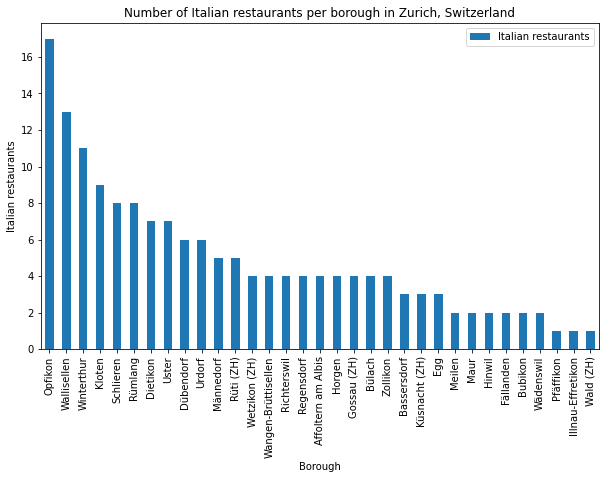

In [34]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
#plot the data
df_zurichgrouped.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Italian restaurants') # add y-label to the plot
plt.title('Number of Italian restaurants per borough in Zurich, Switzerland') # add title to the plot

plt.show()

In [35]:
print('There are {} uniques categories.'.format(len(zurich_venues['Venue Category'].unique())))

There are 6 uniques categories.


In [36]:
# one hot encoding
zurich_onehot = pd.get_dummies(zurich_venues[['Venue Category']], prefix="", prefix_sep="")

# add borough column back to dataframe
zurich_onehot['Borough'] = zurich_venues['Borough'] 

# move borough column to the first column
fixed_columns = [zurich_onehot.columns[-1]] + list(zurich_onehot.columns[:-1])
zurich_onehot = zurich_onehot[fixed_columns]

zurich_onehot.head()

,Borough,Coffee Shop,Hotel,Ice Cream Shop,Italian Restaurant,Pizza Place,Trattoria/Osteria
0,Winterthur,0,0,0,1,0,0
1,Winterthur,0,0,0,1,0,0
2,Winterthur,0,0,0,1,0,0
3,Winterthur,0,0,0,1,0,0
4,Winterthur,0,0,0,1,0,0


In [37]:
zurich_onehot.shape

(162, 7)

In [62]:
zurich_grouped = zurich_onehot.groupby('Borough').mean().reset_index()
zurich_grouped

,Borough,Coffee Shop,Hotel,Ice Cream Shop,Italian Restaurant,Pizza Place,Trattoria/Osteria
0,Affoltern am Albis,0.000000,0.00,0.00,1.000000,0.0,0.00
1,Bassersdorf,0.000000,0.00,0.00,1.000000,0.0,0.00
2,Bubikon,0.000000,0.00,0.00,1.000000,0.0,0.00
3,Bülach,0.000000,0.00,0.00,0.750000,0.0,0.25
4,Dietikon,0.000000,0.00,0.00,1.000000,0.0,0.00
5,Dübendorf,0.000000,0.00,0.00,1.000000,0.0,0.00
6,Egg,0.000000,0.00,0.00,1.000000,0.0,0.00
7,Fällanden,0.000000,0.00,0.00,1.000000,0.0,0.00
8,Gossau (ZH),0.000000,0.00,0.00,1.000000,0.0,0.00
9,Hinwil,0.000000,0.00,0.00,1.000000,0.0,0.00


In [39]:
df_zurichdata = pd.merge(df_final_focus, df_zurichgrouped['Italian restaurants'],on='Borough', how='left')
df_zurichdata.head()

,BFS-Nr,ZIP,Canton,Latitude,Longitude,Borough,Population 2018,Change in % 2010-2018,Population density per km2,Number of households,Average household size,Employed persons,Number of workplaces,Empty apartments,New apartments per 1000 residents,Social welfare quota,Italian restaurants
0,230,8400,ZH,47.499503,8.737565,Winterthur,111851,10.4,1643,50776,2.2,71832,7927,0.75,2.5,5.6,11.0
1,198,8606,ZH,47.352394,8.724760,Uster,34722,7.6,1219,15313,2.2,16795,2410,2.17,3.4,1.7,7.0
2,293,8804,ZH,47.211005,8.657193,Wädenswil,24341,4.7,683,10371,2.3,9624,1867,0.69,5.5,2.3,2.0
3,191,8044,ZH,47.389208,8.610264,Dübendorf,28678,15.5,2106,13087,2.2,20246,1855,1.07,9.4,1.7,6.0
4,121,8620,ZH,47.327357,8.813894,Wetzikon (ZH),24809,12.2,1476,10575,2.3,14194,1800,2.18,3.0,3.5,4.0


In [40]:
df_zurichdata.shape

(36, 17)

In [41]:
df_zurichdata['Italian Restaurants per X people'] = df_zurichdata['Population 2018']/df_zurichdata['Italian restaurants']
df_zurichdata['Italian Restaurants per X workplaces'] = df_zurichdata['Number of workplaces']/df_zurichdata['Italian restaurants']
df_zurichdata = df_zurichdata.sort_values(by=['Italian Restaurants per X people'], ascending=False)
df_zurichdata.head(10)

,BFS-Nr,ZIP,Canton,Latitude,Longitude,Borough,Population 2018,Change in % 2010-2018,Population density per km2,Number of households,Average household size,Employed persons,Number of workplaces,Empty apartments,New apartments per 1000 residents,Social welfare quota,Italian restaurants,Italian Restaurants per X people,Italian Restaurants per X workplaces
17,296,8307,ZH,47.430953,8.723401,Illnau-Effretikon,17068,6.5,519,7585,2.2,6822,1052,1.10,2.5,3.9,1.0,17068.000000,1052.000000
2,293,8804,ZH,47.211005,8.657193,Wädenswil,24341,4.7,683,10371,2.3,9624,1867,0.69,5.5,2.3,2.0,12170.500000,933.500000
22,177,8330,ZH,47.355366,8.794004,Pfäffikon,11935,12.3,611,5269,2.2,5674,811,1.81,4.0,1.7,1.0,11935.000000,811.000000
0,230,8400,ZH,47.499503,8.737565,Winterthur,111851,10.4,1643,50776,2.2,71832,7927,0.75,2.5,5.6,11.0,10168.272727,720.636364
26,120,8636,ZH,47.271079,8.922132,Wald (ZH),9949,10.9,394,4334,2.3,3521,676,2.98,8.1,2.4,1.0,9949.000000,676.000000
16,156,8706,ZH,47.268091,8.639900,Meilen,14220,13.1,1191,6204,2.3,5934,1110,2.83,8.5,1.5,2.0,7110.000000,555.000000
4,121,8620,ZH,47.327357,8.813894,Wetzikon (ZH),24809,12.2,1476,10575,2.3,14194,1800,2.18,3.0,3.5,4.0,6202.250000,450.000000
7,295,8135,ZH,47.246379,8.584535,Horgen,22665,7.6,735,9685,2.3,10082,1418,0.65,6.1,2.7,4.0,5666.250000,354.500000
20,117,8340,ZH,47.300077,8.856827,Hinwil,11138,7.3,500,4899,2.2,7013,860,1.93,9.0,2.6,2.0,5569.000000,430.000000
14,53,8180,ZH,47.517071,8.540864,Bülach,20447,16.8,1271,8889,2.3,10722,1245,1.75,8.9,2.4,4.0,5111.750000,311.250000


In [64]:
df_zurichprio = df_zurichdata.copy()
df_zurichprio.drop(['BFS-Nr', 'Latitude', 'Longitude', 'ZIP', 'Canton', 'New apartments per 1000 residents','Empty apartments','Population density per km2','Average household size', 'Social welfare quota', 'Number of households', 'Change in % 2010-2018'],axis=1, inplace=True)
df_zurichprio.head()

,Borough,Population 2018,Employed persons,Number of workplaces,Italian restaurants,Italian Restaurants per X people,Italian Restaurants per X workplaces
17,Illnau-Effretikon,17068,6822,1052,1.0,17068.000000,1052.000000
2,Wädenswil,24341,9624,1867,2.0,12170.500000,933.500000
22,Pfäffikon,11935,5674,811,1.0,11935.000000,811.000000
0,Winterthur,111851,71832,7927,11.0,10168.272727,720.636364
26,Wald (ZH),9949,3521,676,1.0,9949.000000,676.000000


### Overview of the Italian restaurants in the top 5 boroughs: ###
**The Top5 is referring to "number of Italian restaurants per borough population**

In [42]:
#Create a new dataframe for the top 5 rates per population:
top5_list = ['Illnau-Effretikon', 'Wädenswil', 'Pfäffikon', 'Winterthur', 'Wald (ZH)']
df_top5_italian = zurich_venues[zurich_venues['Borough'].isin(top5_list)]
df_top5 = df_zurichdata[df_zurichdata['Borough'].isin(top5_list)]
df_top5_italian

,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Winterthur,47.499503,8.737565,Restaurant Al Giardino,47.494340,8.739810,Italian Restaurant
1,Winterthur,47.499503,8.737565,Molino,47.499554,8.727712,Italian Restaurant
2,Winterthur,47.499503,8.737565,Cantinetta Bindella,47.499667,8.728742,Italian Restaurant
3,Winterthur,47.499503,8.737565,Santa Lucia,47.501045,8.725249,Italian Restaurant
4,Winterthur,47.499503,8.737565,La Pergola,47.500243,8.729235,Italian Restaurant
5,Winterthur,47.499503,8.737565,Ristorante La Torre,47.497981,8.723812,Italian Restaurant
6,Winterthur,47.499503,8.737565,San Remo,47.507193,8.725907,Italian Restaurant
7,Winterthur,47.499503,8.737565,Restaurant Gutschick,47.491842,8.750220,Italian Restaurant
8,Winterthur,47.499503,8.737565,Gerry's Bar,47.504525,8.763603,Italian Restaurant
9,Winterthur,47.499503,8.737565,La Vita,47.494019,8.710929,Italian Restaurant


In [43]:
map_top5_italian = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_top5_italian['Venue Latitude'], df_top5_italian['Venue Longitude'], df_top5_italian['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=505,
        popup=label,
        color='black',
        weight = 1,
        fill=True,
        fill_color='#16f06d',
        fill_opacity=0.9,
        parse_html=False).add_to(map_top5_italian)  
    
map_top5_italian

### As an alternative for the Top 5, I will now extract all venues for the Zurich boroughs (excl. the city of Zurich) and cluster them, in order to see if there is a wider area available ###

In [44]:
CLIENT_ID = '41ODMMQ4XVXADDYW3DD0QN2XG4WJXFUKIWFRXWFQQHYSY4LJ' # your Foursquare ID
CLIENT_SECRET = '05PDO01BUKSJHUA3OG5YEHXYIQROO3NEI5T222QQGY4AV4DF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
# categoryId = '4bf58dd8d48988d110941735' # or '4bf58dd8d48988d158941735'  #the list of restaurants in scope

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 41ODMMQ4XVXADDYW3DD0QN2XG4WJXFUKIWFRXWFQQHYSY4LJ
CLIENT_SECRET:05PDO01BUKSJHUA3OG5YEHXYIQROO3NEI5T222QQGY4AV4DF


In [45]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [46]:
all_venues = getNearbyVenues(names=df_final['Borough'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude']
                                  )
all_venues.head()

Winterthur
Uster
Wädenswil
Dübendorf
Wetzikon (ZH)
Dietikon
Kloten
Horgen
Wallisellen
Schlieren
Opfikon
Regensdorf
Küsnacht (ZH)
Volketswil
Bülach
Zollikon
Meilen
Illnau-Effretikon
Stäfa
Affoltern am Albis
Hinwil
Rüti (ZH)
Pfäffikon
Richterswil
Männedorf
Rümlang
Wald (ZH)
Urdorf
Gossau (ZH)
Bassersdorf
Maur
Hombrechtikon
Egg
Wangen-Brüttisellen
Bubikon
Fällanden
Embrach
Niederhasli
Seuzach
Fehraltorf
Herrliberg
Dürnten
Dielsdorf
Birmensdorf (ZH)
Bäretswil
Bauma
Wiesendangen
Uetikon am See
Langnau am Albis
Neftenbach
Lindau
Elgg
Zell (ZH)
Turbenthal
Eglisau
Mettmenstetten
Obfelden
Schwerzenbach
Oberglatt
Nürensdorf
Wettswil am Albis
Oetwil am See
Buchs (ZH)
Russikon
Dällikon
Bonstetten
Grüningen
Weiningen (ZH)
Stammheim
Hausen am Albis
Uitikon
Winkel
Otelfingen
Glattfelden
Unterengstringen
Neerach
Mönchaltorf
Hittnau
Rafz
Niederglatt
Elsau
Weisslingen
Pfungen
Marthalen
Höri
Steinmaur
Fischenthal
Hedingen
Kleinandelfingen
Stallikon
Andelfingen
Ottenbach
Hettlingen
Rickenbach (ZH)
Wila
Fr

,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Winterthur,47.499503,8.737565,La Cyma,47.498514,8.732239,Café
1,Winterthur,47.499503,8.737565,Fotomuseum Winterthur,47.495739,8.738024,Art Museum
2,Winterthur,47.499503,8.737565,Tibits,47.499980,8.731118,Vegetarian / Vegan Restaurant
3,Winterthur,47.499503,8.737565,Alte Kaserne,47.497778,8.731679,Public Art
4,Winterthur,47.499503,8.737565,Restaurant Widder,47.498649,8.727839,Gastropub


### Clustering of the different venues for the Zurich boroughs ###

In [47]:
all_venues.groupby('Borough').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Adlikon,8,8,8,8,8,8
Aesch (ZH),13,13,13,13,13,13
Aeugst am Albis,6,6,6,6,6,6
Affoltern am Albis,9,9,9,9,9,9
Altikon,4,4,4,4,4,4
Andelfingen,5,5,5,5,5,5
Bachs,7,7,7,7,7,7
Bassersdorf,22,22,22,22,22,22
Bauma,8,8,8,8,8,8


In [48]:
print('There are {} uniques categories.'.format(len(all_venues['Venue Category'].unique())))

There are 223 uniques categories.


### Analyze each borough: ###

In [49]:
# one hot encoding
all_venues_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add borough column back to dataframe
all_venues_onehot['Borough'] = all_venues['Borough'] 

# move borough column to the first column
fixed_columns = [all_venues_onehot.columns[-1]] + list(all_venues_onehot.columns[:-1])
all_venues_onehot = all_venues_onehot[fixed_columns]

all_venues_onehot.head()

,Borough,ATM,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Camera Store,Campground,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kebab Restaurant,Korean Restaurant,Lake,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,Newsstand,Nightclub,Non-Profit,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Palace,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,River,Road,Rock Climbing Spot,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Ski Trail,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Winery,Zoo,Zoo Exhibit
0,Winterthur,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Winterthur,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Winterthur,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [50]:
all_venues_grouped = all_venues_onehot.groupby('Borough').mean().reset_index()
all_venues_grouped

,Borough,ATM,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Camera Store,Campground,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kebab Restaurant,Korean Restaurant,Lake,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,Newsstand,Nightclub,Non-Profit,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Palace,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,River,Road,Rock Climbing Spot,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Ski Trail,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Winery,Zoo,Zoo Exhibit
0,Adlikon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.125000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000

__Print each neighborhood along with the top 5 most common venues__:

In [51]:
num_top_venues = 5

for hood in all_venues_grouped['Borough']:
    print("----"+hood+"----")
    temp = all_venues_grouped[all_venues_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adlikon----
                        venue  freq
0                  Restaurant  0.38
1               Grocery Store  0.25
2               Train Station  0.25
3  Construction & Landscaping  0.12
4                         ATM  0.00


----Aesch (ZH)----
               venue  freq
0   Swiss Restaurant  0.15
1              Diner  0.08
2        Pizza Place  0.08
3  Food & Drink Shop  0.08
4             Bakery  0.08


----Aeugst am Albis----
              venue  freq
0  Swiss Restaurant  0.50
1              Lake  0.17
2              Road  0.17
3        Campground  0.17
4               ATM  0.00


----Affoltern am Albis----
                  venue  freq
0         Grocery Store  0.33
1         Train Station  0.22
2      Department Store  0.11
3           Gas Station  0.11
4  Fast Food Restaurant  0.11


----Altikon----
                     venue  freq
0                     Park  0.25
1         Swiss Restaurant  0.25
2  Health & Beauty Service  0.25
3            Train Station  0.25
4          

In [52]:
# Check most frequent for Top 5 for earlier:
# top5_list = ['Illnau-Effretikon', 'Wädenswil', 'Pfäffikon', 'Winterthur', 'Wald (ZH)']
df_top5_italian_freq = all_venues_grouped[all_venues_grouped['Borough'].isin(top5_list)]
# df_top5 = all_venues_grouped[all_venues_grouped['Borough'].isin(top5_list)]

num_top_venues = 5

for hood in df_top5_italian_freq['Borough']:
    print("----"+hood+"----")
    temp = df_top5_italian_freq[df_top5_italian_freq['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Illnau-Effretikon----
              venue  freq
0        Restaurant  0.33
1       Supermarket  0.17
2  Swiss Restaurant  0.17
3              Café  0.17
4            Lounge  0.17


----Pfäffikon----
                  venue  freq
0            Restaurant  0.13
1      Swiss Restaurant  0.13
2         Grocery Store  0.07
3         Train Station  0.07
4  Fast Food Restaurant  0.07


----Wald (ZH)----
                        venue  freq
0                  Restaurant  0.29
1                      Bakery  0.14
2                 Gas Station  0.14
3                 Supermarket  0.14
4  Construction & Landscaping  0.14


----Winterthur----
                venue  freq
0                Café  0.09
1                 Bar  0.08
2          Restaurant  0.07
3  Italian Restaurant  0.05
4         Supermarket  0.04


----Wädenswil----
                  venue  freq
0           Supermarket  0.18
1                 Hotel  0.18
2            Food Court  0.09
3  Fast Food Restaurant  0.09
4         Train Station

__Put data into a Pandas dataframe__:

In [53]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Borough'] = all_venues_grouped['Borough']

for ind in np.arange(all_venues_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_venues_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlikon,Restaurant,Grocery Store,Train Station,Construction & Landscaping,Falafel Restaurant,French Restaurant,Forest,Food Service,Food Court,Food & Drink Shop
1,Aesch (ZH),Swiss Restaurant,Diner,Food & Drink Shop,Golf Course,Supermarket,Bus Station,Train Station,Bakery,Hockey Arena,Photography Studio
2,Aeugst am Albis,Swiss Restaurant,Campground,Lake,Road,Zoo Exhibit,Fried Chicken Joint,French Restaurant,Forest,Food Service,Food Court
3,Affoltern am Albis,Grocery Store,Train Station,Gas Station,Department Store,Bakery,Fast Food Restaurant,Farmers Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant
4,Altikon,Health & Beauty Service,Swiss Restaurant,Train Station,Park,Falafel Restaurant,Fried Chicken Joint,French Restaurant,Forest,Food Service,Food Court


### Clustering: ###

In [54]:
# set number of clusters
kclusters = 3

all_venues_grouped_clustering = all_venues_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 0, 2, 0, 2, 0, 0, 2, 0], dtype=int32)

In [55]:
# add clustering labels
borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [56]:
all_venues_merged = zurich_venues

# merge all_venues_merged with zurich_venues to add latitude/longitude for each borough
all_venues_merged = all_venues_merged.join(borough_venues_sorted.set_index('Borough'), on='Borough')

all_venues_merged.head() # check the last columns!

,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Winterthur,47.499503,8.737565,Restaurant Al Giardino,47.494340,8.739810,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
1,Winterthur,47.499503,8.737565,Molino,47.499554,8.727712,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
2,Winterthur,47.499503,8.737565,Cantinetta Bindella,47.499667,8.728742,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
3,Winterthur,47.499503,8.737565,Santa Lucia,47.501045,8.725249,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
4,Winterthur,47.499503,8.737565,La Pergola,47.500243,8.729235,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar


### Now I visualise the resulting clusters: ###

In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_venues_merged['Latitude'], all_venues_merged['Longitude'], all_venues_merged['Borough'], all_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [66]:
all_venues_merged.loc[all_venues_merged['Cluster Labels'] == 1, all_venues_merged.columns[[1] + list(range(5, all_venues_merged.shape[1]))]]

,Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,47.499503,8.739810,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
1,47.499503,8.727712,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
2,47.499503,8.728742,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
3,47.499503,8.725249,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
4,47.499503,8.729235,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
5,47.499503,8.723812,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
6,47.499503,8.725907,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
7,47.499503,8.750220,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
8,47.499503,8.763603,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar
9,47.499503,8.710929,Italian Restaurant,1,Café,Bar,Restaurant,Italian Restaurant,Supermarket,Art Museum,Nightclub,Swiss Restaurant,Shopping Mall,Cocktail Bar


**As we can see, there are basically three different clusters available. As cluster "1" ist the one with Cafés, Bars and Restaurants being the most common venues, I name this one "Food and Drinks". The other clusters are excluded for the moment, as they are not a direct competition to the Italian restaurant.**

**Most important is that based on the earlier analysis that we did, we see exactly one borough that has no restaurant in the Top 5 frequency table, but was part of the Top5 borough list: Wädenswil. This means I will further focus here. According to the ealier analysis of the Foursquare data, there is only two Italian restuarants here. Both do not have a rating on Foursquare.**


### Get the rating of an Italian restaurant from Foursquare: ###

In [59]:
VENUE_ID = '4bf58dd8d48988d110941735' #This is the ID of "A Casa Di Luca", as retrieved earlier (used for test purpose)

def getPfaeffikon(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&VENUE_ID={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
        VENUE_ID)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['rating']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'
                  'Venue Rating']
    
    return(nearby_venues)

**Unfortunately, it is only possible to retreive one rating per day with the free account on Foursquare. In Wädenswil, "Gustav" and "Pizzeria Romantica" have no rating on Foursquare (this was double-checked through the mobile app). Therefore, we receive no result through the API. They have a 4.7 and 4.3 (out of 5) rating on Google though, which is quite good.**

This concludes our analysis of the boroughs in Zurich. I have focused on the ones with the highest density of businesses (>500) in order to make sure I have a large enough potential for "walk-in" customers during the day. I then checked the number of Italian restaurants for all of the Zurich boroughs and focused on the Top 5 "restaurants per population". Additionally, I analysed the clustered venues of the Zurich boroughs in order to see, if there is any area that does not belong to a "Food and Drinks" cluster. 

## 4. Results and Discussion:

My analysis showed that there are 4133 cities in the canton of Zurich in Switzerland. Grouping these into boroughs makes a lot of sense in order to make them "economically viable" when analyzing for a valid location for an Italian restaurant. Additionally, I merged the location data with the economical data of the boroughs. The latter was not available on a city level.
Once grouped, I was left with 162 borough in the canton of Zurich. Thus number was further reduced to 143, as some missed information about the population and number of businesses. 

As the Italian resturant planned to be opened should also serve customers from local business (walk-in customers), I decided to only look at the boroughs that had at least 500 businesses in the area. This cut our an additional 107 boroughs, which left me with 36 in scope. I plotted these on a map to check if the location data makes sense (as I took the average location from all cities in the respective borough). I had to correct location of the borough of "Winterthur" only, all others were ok. As the city of Zurich was too large for this and exceeded the Foursquare API data limit anyways, I also cut it out to end up with 35 boroughs.
The plot included a radius of 2.5km, which was a reasonable area to not have too much overlap between the remaining boroughs and large enough to make sure the relevant venues are include to provide good enough results of the search for restaurant. Of course, one could play around with the radius, based on assumptions how mobile people are (walking, by food or with public transportation).

The same radius of 2.5k was then also used to retreive the data from the Foursquare API. I deliberately only focused on the category of "Italian restaurants" this time, including name and location of the restaurants. I then grouped the number of restaurants per borough. Afterwards, I calculated the number of restaurants per population and per number of businesses per borough and generated a Top 5 list, based on "Restaurants per population". The Top 5 borough were:
* Illnau-Effretikon
* Pfäffikon
* Wädenswil
* Wald (ZH)
* Winterthur

As an additional information for my decision I then took the 36 relevant borough mentioned earlier and retreived the venue information from Foursquare for all of them. I then generated clusters, which left me with three clusters overall, which were named "Restaurants" (cluster 0) "Food and drinks" (cluster 1) and "Groceries" (cluster 2). All Top 5 boroughs from above were in cluster 1. As this was not helpful, I generated the frequency tables with the top 5 clusters per borough and checked the frequency of resturants or similar foe each of them. It turned out that only "Wädenswil" had no restaurants in the top 5. Therefore, I decided that this would be a good focus borough for an Italian restaurant. 

Finally, I attenpted to receive a rating from Foursquare, but it turned out that both Italian restaurants in the borough do not have one. I then consulted Google to get at least a rating from there and both already have a good rating ("Gustav": 4.7 and "Pizzaria Romantica": 4.3). 

Wädenswil seems to be a good choice, as it has the second-highest number (of the 36 focus boroughs) for "Populations per Italian restaurant" and "Number of businesses per Italian restaurant" in the entire canton. Additionally to this, the social welfare quota of 2.3% is quite low (sencond-lowest of the Top 5 boroughs) and it has a nice location at the lake. Thus, there will possibily also be tourists visiting.

Of course, looking only at boroughs with at least 500 businesses as a first filter does not mean the other areas do not have any potential. If the focus would be low competition only in a promising borough then it would also make sense to look at the density of restaurants overall. Zurich is a high-income canton in Switzerland and most people can affort to dine out on a regaular basis. Also, excluding Zurich city from the analysis could raise some doubts. While the city was out of scope for this analysis, one could divide the city and look for low-density restaurant area there. The advantage of the city is that it has a dense public transportation network and people can move around easily. 
Another area I didn't touch is the potential rent of a restaurant: depending on the area, this can be very different. While the rent Zurich city is certainly very high, other boroughs are much cheaper. This of course has to be weighted against the tax rates, which change with the borough. This might be an area to look at for future analysis.


## 5. Conclusion

The purpose of this analysis was to find out where it would be feasible to open an Italian restaurant in the canton of Zurich, Switzerland. I first narrowed down the search to boroughs with a reasonable population and number of businesses and then gathered the Foursquare data for Italian restaurants. After generating the restaurant density per population and businesses, I used the Foursquare API to get additional data on the venues for the Top 5 boroughs. These were clustered and the venues with the highest frequency analysed. Based on the comparison to the density of Italian restaurants, the borough of Wädenswil was picked as a target area that should be further evaluated.

Overall, opening an Italian restaurant in Wädenswil has high potential with a relatively high population and cutomer potential, low competition and a nice location. Of course, one should get familiar further with the borough and visit it, to get more impressions. Talking to people living on site would also help to get more insights before making a final decision for investment.